In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [33]:
df = pd.read_csv("super_rugby_oddsportal.csv").drop('Play-off Game?', axis=1).dropna()

In [34]:
spare = pd.read_csv("super_rugby_oddsportal.csv").drop('Play-off Game?', axis=1).dropna()

In [35]:
df.head(7)

,Date,Home Team,Away Team,Home Score,Away Score,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,8-Mar-19,Hurricanes,Highlanders,0.0,0.0,1.29,24.79,3.68,11.0
1,8-Mar-19,Rebels,Brumbies,0.0,0.0,1.57,21.82,2.46,11.0
2,9-Mar-19,Crusaders,Chiefs,0.0,0.0,1.15,30.29,5.49,10.0
3,9-Mar-19,Blues,Sunwolves,0.0,0.0,1.16,30.49,5.23,10.0
4,9-Mar-19,Waratahs,Reds,0.0,0.0,1.32,25.18,3.44,10.0
5,9-Mar-19,Lions,Jaguares,0.0,0.0,1.28,24.44,3.77,10.0
6,9-Mar-19,Bulls,Sharks,0.0,0.0,1.53,21.68,2.55,10.0


### Get win streak

In [36]:
def bool_to_int(bool_val):
    if bool_val:
        return 1
    else:
        return -1

def get_home_streak(team, date):
    
    date_df = df[df['Date'] < date]
    team_df = date_df[date_df['Home Team']==team].sort_values('Date', ascending=False)
    results = team_df.itertuples()
    try: 
        last_result = bool_to_int(next(results)[-1])
        streak = last_result
    except:
        streak = 0
    
    while True:
        try:
            next_result = bool_to_int(next(results)[-1])
            if next_result == last_result:
                streak += next_result
            else:
                break
        except:
            break
    
    return streak
        

def get_away_streak(team, date):
    
    date_df = df[df['Date'] < date]
    team_df = date_df[date_df['Away Team']==team].sort_values('Date', ascending=False)
    results = team_df.itertuples()
    try:
        last_result = bool_to_int(next(results)[-1])*-1
        streak = last_result
    except:
        streak = 0
    
    while True:
        try:
            next_result = bool_to_int(next(results)[-1])*-1
            if next_result == last_result:
                streak += next_result
            else:
                break
        except:
            break
    
    return streak

### Cleaning and Feature Engineering

In [37]:
countries = {'Crusaders': 'NZ',
             'Chiefs': 'NZ',
             'Blues': 'NZ',
             'Hurricanes': 'NZ',
             'Highlanders': 'NZ',
             'Bulls': 'SA',
             'Cheetahs': 'SA',
             'Kings': 'SA',
             'Lions': 'SA',
             'Sharks': 'SA',
             'Stormers': 'SA',
             'Brumbies': 'AUS',
             'Force': 'AUS',
             'Rebels': 'AUS',
             'Reds': 'AUS',
             'Waratahs': 'AUS',
             'Jaguares': 'ARG',
             'Sunwolves': 'JPN'}

def cleanup(df):
    
    # convert Date to datetime
    df['Date'] = pd.to_datetime(df.Date)
    
    # create response variable
    df['home_margin'] = df['Home Score'] - df['Away Score']
    
    # create home_win column
    df['home_win'] = (df['Home Score'] > df['Away Score'])
    
    df.drop(['Home Score', 'Away Score'], axis=1, inplace=True)
    
    # create home_streak and away_streak columns
    home_streaks = []
    away_streaks = []
    for row in df.itertuples():
        home_team = row[2]
        away_team = row[3]
        date = row[1]
        home_streaks.append(get_home_streak(home_team, date))
        away_streaks.append(get_away_streak(away_team, date))
        
    df['home_streak'] = home_streaks
    df['away_streak'] = away_streaks
    
    # add nationalities
    df['home_nationality'] = df['Home Team'].replace(countries)
    df['away_nationality'] = df['Away Team'].replace(countries)
    
    # encode nationalities
    df = pd.get_dummies(df, prefix='home_country', columns=['home_nationality'])
    df = pd.get_dummies(df, prefix='away_country', columns=['away_nationality'])
    
    # encode team names
    df = pd.get_dummies(df, prefix='home_team', columns=['Home Team'])
    df = pd.get_dummies(df, prefix='away_team', columns=['Away Team'])
    
    # aggregate odds into single probability variable
    df['home_odds'] = df['Away Odds'] / (df['Home Odds'] + df['Away Odds'])
    
    # drop irrelevent columns
    df.drop(['Date', 'Home Odds', 'Draw Odds', 'Away Odds', 'Bookmakers Surveyed',
             'home_country_ARG', 'home_country_JPN', 'away_country_ARG',
             'away_country_JPN', 'home_team_Cheetahs', 'away_team_Cheetahs',
             'home_team_Kings', 'away_team_Kings', 'home_team_Force',
             'away_team_Force'], 
            axis=1,
            inplace=True)
    
    return df

In [38]:
df = cleanup(df)
df.head(15)

,home_margin,home_win,home_streak,away_streak,home_country_AUS,home_country_NZ,home_country_SA,away_country_AUS,away_country_NZ,away_country_SA,...,away_team_Hurricanes,away_team_Jaguares,away_team_Lions,away_team_Rebels,away_team_Reds,away_team_Sharks,away_team_Stormers,away_team_Sunwolves,away_team_Waratahs,home_odds
0,0.0,False,11,-1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.740443
1,0.0,False,1,-1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.610422
2,0.0,False,21,-2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.826807
3,0.0,False,-1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.818466
4,0.0,False,-1,-7,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0.722689
5,0.0,False,-1,-3,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0.746535
6,0.0,False,2,1,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0.625000
7,-15.0,False,-1,-23,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.921613
8,-10.0,False,2,7,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.179128
9,-18.0,False,5,-5,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0.694013


In [39]:
import seaborn as sns

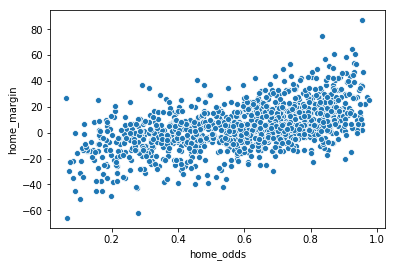

In [40]:
sns.scatterplot(x='home_odds', y='home_margin', data=df)

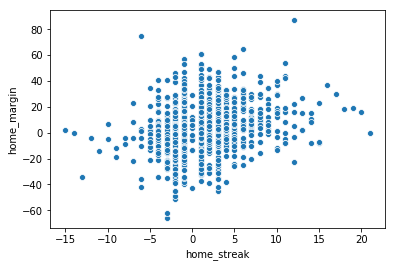

In [41]:
sns.scatterplot(x='home_streak', y='home_margin', data=df)

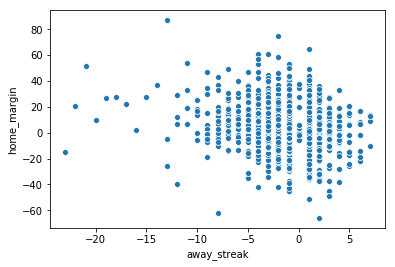

In [42]:
sns.scatterplot(x='away_streak', y='home_margin', data=df)

In [43]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
home_margin,1234.0,4.494327,17.329788,-66.000000,-6.000000,4.000000,15.000000,87.000000
home_streak,1234.0,1.194489,3.819033,-15.000000,-1.000000,1.000000,3.000000,21.000000
away_streak,1234.0,-1.154781,3.419025,-23.000000,-3.000000,-1.000000,1.000000,7.000000
home_country_AUS,1234.0,0.298217,0.457661,0.000000,0.000000,0.000000,1.000000,1.000000
home_country_NZ,1234.0,0.329011,0.470045,0.000000,0.000000,0.000000,1.000000,1.000000
home_country_SA,1234.0,0.331442,0.470923,0.000000,0.000000,0.000000,1.000000,1.000000
away_country_AUS,1234.0,0.298217,0.457661,0.000000,0.000000,0.000000,1.000000,1.000000
away_country_NZ,1234.0,0.333874,0.471786,0.000000,0.000000,0.000000,1.000000,1.000000
away_country_SA,1234.0,0.327391,0.469451,0.000000,0.000000,0.000000,1.000000,1.000000
home_team_Blues,1234.0,0.064019,0.244887,0.000000,0.000000,0.000000,0.000000,1.000000


### TO DO: Engineer more features which capture form, attack, defense etc
Would like to create a function that finds the last 5 fixtures for each team, or something along those lines.

In [44]:
X = df[7:].drop(['home_margin', 'home_win'], axis=1)
y = df[7:].home_margin.values

In [50]:
# we will use these later:
X_temp = df[:7].drop(['home_margin', 'home_win'], axis=1)
y_temp = df[:7].home_margin.values

In [45]:
y.shape

(1227,)

In [46]:
X.shape

(1227, 39)

In [47]:
y.shape

(1227,)

## Model Preparation: TPOT

(Install TPOT [here](http://epistasislab.github.io/tpot/installing/))

To do:

- Train/test split
- Set up neural network
- Train
- Check test accuracy
- Predict with week 2 data

In [48]:
# set up train/test split with 80/20 proportion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
from tpot import TPOTRegressor

C:\Users\jlesl\Anaconda3\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)
C:\Users\jlesl\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [21]:
tpot = TPOTRegressor(verbosity=2, max_time_mins=10)

In [22]:
tpot.fit(X_train, y_train)

C:\Users\jlesl\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Generation 1 - Current best internal CV score: -218.42024068283735
Generation 2 - Current best internal CV score: -218.42024068283735
Generation 3 - Current best internal CV score: -217.41967508850547
Generation 4 - Current best internal CV score: -217.41967508850547
Generation 5 - Current best internal CV score: -216.91582421995972
Generation 6 - Current best internal CV score: -216.91582421995972
Generation 7 - Current best internal CV score: -216.91582421995972
Generation 8 - Current best internal CV score: -216.91582421995972
Generation 9 - Current best internal CV score: -216.91582421995972
Generation 10 - Current best internal CV score: -216.8006235003758

10.003915216666666 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=1, min_child_weight=5, n_estimators=100, nthread=1, subsample=0.45)


TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
       disable_update_check=False, early_stop=None, generations=1000000,
       max_eval_time_mins=5, max_time_mins=10, memory=None,
       mutation_rate=0.9, n_jobs=1, offspring_size=None,
       periodic_checkpoint_folder=None, population_size=100,
       random_state=None, scoring=None, subsample=1.0, use_dask=False,
       verbosity=2, warm_start=False)

In [25]:
np.sqrt(tpot.score(X_test, y_test)*-1)

14.529328957354357

In [28]:
tpot.export('tpot_titanic_pipeline.py')

Take a look at the model that TPOT created:

In [30]:
!type tpot_titanic_pipeline.py

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=None)

# Average CV score on the training set was:-216.8006235003758
exported_pipeline = XGBRegressor(learning_rate=0.1, max_depth=1, min_child_weight=5, n_estimators=100, nthread=1, subsample=0.45)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


---

In [31]:
# Use the model's predict method on the test data
np.sqrt(mean_squared_error(tpot.predict(X_test), y_test))

14.529328957354357

In [32]:
mean_absolute_error(y_test, tpot.predict(X_test))

11.189158665213158

## Make predictions for upcoming week

In [51]:
# predict for upcoming week
np.vstack((tpot.predict(X_temp), spare['Home Team'][:7], spare['Away Team'][:7])).T

array([[9.974663734436035, 'Hurricanes', 'Highlanders'],
       [2.02592396736145, 'Rebels', 'Brumbies'],
       [16.869142532348633, 'Crusaders', 'Chiefs'],
       [21.457897186279297, 'Blues', 'Sunwolves'],
       [11.713139533996582, 'Waratahs', 'Reds'],
       [10.649018287658691, 'Lions', 'Jaguares'],
       [7.042428016662598, 'Bulls', 'Sharks']], dtype=object)

In [52]:
temp = np.vstack((tpot.predict(X_temp), spare['Home Team'][:7], spare['Away Team'][:7])).T

In [56]:
preds_df = pd.DataFrame(temp, columns=["Home_Margin", "Home_Team", "Away_Team"])

In [58]:
preds_df["Home_Margin"] = preds_df.Home_Margin.apply(lambda x: int(np.round(x, 0)))
preds_df

,Home_Margin,Home_Team,Away_Team
0,10,Hurricanes,Highlanders
1,2,Rebels,Brumbies
2,17,Crusaders,Chiefs
3,21,Blues,Sunwolves
4,12,Waratahs,Reds
5,11,Lions,Jaguares
6,7,Bulls,Sharks
